In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os
from tqdm import tqdm

import tensorflow as tf

import keras
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential

from sklearn.model_selection import train_test_split

from keras import metrics
from keras.models import load_model

from keras.models import model_from_json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../input/utk-face-extracted-info/extracted_info.csv')
df.dropna(inplace=True)
df = df[df['Age'] <= 70]
df = df[df['Age'] >= 16]
df = df.reset_index()
df = df.drop(columns = {'DateTime', 'Unnamed: 0', 'index'})

'''
'''
# df['Name'] = df['Name'].apply(lambda x: '../input/utkface-new/UTKFace/' + str(x))
'''
'''
num_classes = len(df['Age'].unique())
df.head()

,Age,Gender,Race,Name
0,42,0.0,0,../input/utkface-uncropped-dataset/Images/42_0...
1,35,1.0,0,../input/utkface-uncropped-dataset/Images/35_1...
2,26,0.0,3,../input/utkface-uncropped-dataset/Images/26_0...
3,42,1.0,1,../input/utkface-uncropped-dataset/Images/42_1...
4,28,0.0,3,../input/utkface-uncropped-dataset/Images/28_0...


## Visualising Some Images in the Dataset

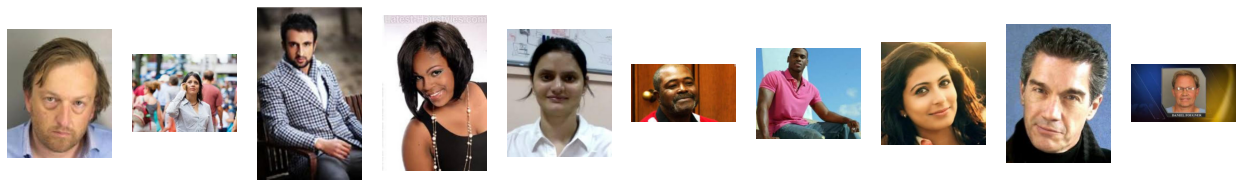

In [3]:
fig = plt.figure(figsize=(22, 5))
for i in range(10):  
    fig.add_subplot(1, 10, i+1)
    img = mpimg.imread(df.iloc[i]['Name'])
#     img = np.random.randint(10, size=(h,w))
    plt.imshow(img)
    plt.axis('off')
#     plt.title("Figure" + str(i))
plt.show()

## Race Wise Distribution Of Different Age Groups

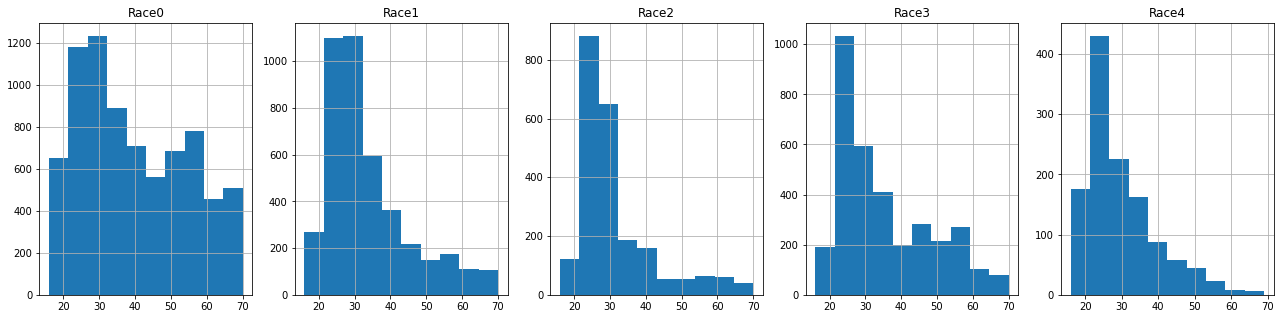

In [4]:
fig = plt.figure(figsize=(45, 5))
for i in range(5):  
    fig.add_subplot(1, 10, i+1)
    df[df['Race'] == i]['Age'].hist()
    plt.title("Race" + str(i))
plt.show()

## Age, Gender and Race Distribution in the original Dataset

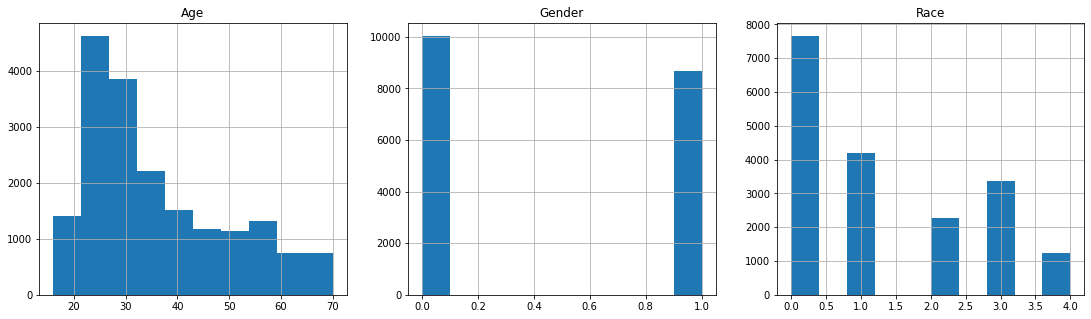

In [5]:
fig = plt.figure(figsize=(65, 5))
fig.add_subplot(1, 10, 1)
df['Age'].hist()
plt.title("Age")
fig.add_subplot(1, 10, 2)
df['Gender'].hist()
plt.title("Gender")
fig.add_subplot(1, 10, 3)
df['Race'].hist()
plt.title("Race")
plt.show()

In [6]:
'''
len(df[df['Age']>93]['Age']) ------- just 46 people
classes = 101 #(0, 100])
print("number of output classes: ",classes)
'''

df['Age'] = df['Age'] - 16

In [7]:
dff = [1, 2, 3, 4, 5]

train = [1, 2, 3, 4, 5]
df_test = [1, 2, 3, 4, 5]
val = [1, 2, 3, 4, 5]

dff[0] = df[df['Race'] == 0]
dff[1] = df[df['Race'] == 1]
dff[2] = df[df['Race'] == 2]
dff[3] = df[df['Race'] == 3]
dff[4] = df[df['Race'] == 4]

dff[0]['Age'] = dff[0]['Age'].astype('str')
dff[1]['Age'] = dff[1]['Age'].astype('str')
dff[2]['Age'] = dff[2]['Age'].astype('str')
dff[3]['Age'] = dff[3]['Age'].astype('str')
dff[4]['Age'] = dff[4]['Age'].astype('str')

In [8]:
for i in range(5):
    df_data = dff[i].Name
    y_data = dff[i].Age
    X_train, X_test, y_train, y_test = train_test_split(df_data, y_data, test_size=0.20, random_state=40)
    d = {'Name':X_train,'Age':y_train}
    df_train = pd.concat(d,axis=1)

    #################################

    df_data = df_train.Name
    y_data = df_train.Age
    X_train, X_val, y_train, y_val = train_test_split(df_data, y_data, test_size=0.1, random_state=42)
    d = {'Name':X_train,'Age':y_train}
    train[i] = pd.concat(d,axis=1)

    ################################

    d = {'Name':X_val,'Age':y_val}
    val[i] = pd.concat(d,axis=1)

    ################################

    d = {'Name':X_test,'Age':y_test}
    df_test[i] = pd.concat(d,axis=1)

## Generating the Test, Train and Validation Datasets

In [9]:
__train = False

batch = 512
train_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

if __train:
    
    train_data = [1, 1, 1, 1, 1]
    val_data = [1, 1, 1, 1, 1]
    
    for i in range(5):
        train_data[i] = train_gen.flow_from_dataframe(dataframe = train[i], 
                                                   #directory = train_folder, 
                                                   x_col = 'Name',
                                                   y_col = 'Age', seed = 42,
                                                   batch_size = batch,
                                                   shuffle = True, 
                                                   class_mode="sparse",
                                                   target_size = (224, 224))

        val_data[i] = train_gen.flow_from_dataframe(dataframe = val[i], 
                                                   #directory = train_folder, 
                                                   x_col = 'Name',
                                                   y_col = 'Age', seed = 42,
                                                   batch_size = batch,
                                                   shuffle = True, 
                                                   class_mode="sparse",
                                                   target_size = (224, 224))

In [10]:
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())

if __train:
    model.load_weights('../input/vggfaceweights/vgg_face_weights.h5')

base_model_output = Sequential()
base_model_output = Convolution2D(num_classes, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)

In [11]:
_model = Model(inputs=model.input, outputs=base_model_output)
model.output_shape

(None, 2622)

## Training

In [12]:
if __train:
    Models = [_model, _model, _model, _model, _model]

    for i in range(5):
        for layer in Models[i].layers[:-7]:
            layer.trainable = False

        Models[i].compile(
          optimizer='adam',
          loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])

        checkpointer = ModelCheckpoint(
            filepath="./classification_age_model_utk_" + str(i) + ".hdf5"
            , monitor = "val_loss"
            , verbose=1
            , save_best_only=True
            , mode = 'auto'
        )

        callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4)

        history = Models[i].fit(
            train_data[i],
            validation_data=val_data[i],
            epochs= 20,
            callbacks = [checkpointer, callback],
            shuffle=True
        )
        Models[i].load_weights("./classification_age_model_utk_" + str(i) + ".hdf5")
        Models[i].save_weights("age_model_weights_utk_" + str(i) + ".h5")

        ____train = False
        if ____train:
            for layer in Models[i].layers[:-2]:
                layer.trainable = False

            history = Models[i].fit(
                    train_data[i]
                    , epochs=10
                    , validation_data=val_data[i]
                    , callbacks=[checkpointer]
                    , shuffle=True
            )
            Models[i] = load_model("./classification_age_model_utk_" + str(i) + ".hdf5")
            Models[i].save_weights("age_model_weights_utk_" + str(i) + ".h5")

## Testing MAE For Separate Races

In [13]:
df_test[0] = dff[0][['Name', 'Age']]
df_test[1] = dff[1][['Name', 'Age']]
df_test[2] = dff[2][['Name', 'Age']]
df_test[3] = dff[3][['Name', 'Age']]
df_test[4] = dff[4][['Name', 'Age']]

In [14]:
batch = 512
test_gen = ImageDataGenerator(rescale=1./255)

test_data_race = [1, 2, 3 ,4 ,5]
test_data_race[0] = test_gen.flow_from_dataframe(dataframe = df_test[0],
                                         x_col = 'Name',
                                         y_col = 'Age',
                                         batch_size = batch,
                                         shuffle = True,
                                         class_mode='sparse',
                                         target_size = (224, 224))
test_data_race[1] = test_gen.flow_from_dataframe(dataframe = df_test[1],
                                         x_col = 'Name',
                                         y_col = 'Age',
                                         batch_size = batch,
                                         shuffle = True,
                                         class_mode='sparse',
                                         target_size = (224, 224))
test_data_race[2] = test_gen.flow_from_dataframe(dataframe = df_test[2],
                                         x_col = 'Name',
                                         y_col = 'Age',
                                         batch_size = batch,
                                         shuffle = True,
                                         class_mode='sparse',
                                         target_size = (224, 224))
test_data_race[3] = test_gen.flow_from_dataframe(dataframe = df_test[3],
                                         x_col = 'Name',
                                         y_col = 'Age',
                                         batch_size = batch,
                                         shuffle = True,
                                         class_mode='sparse',
                                         target_size = (224, 224))
test_data_race[4] = test_gen.flow_from_dataframe(dataframe = df_test[4],
                                         x_col = 'Name',
                                         y_col = 'Age',
                                         batch_size = batch,
                                         shuffle = True,
                                         class_mode='sparse',
                                         target_size = (224, 224),
                                         validate_filenames=False)

Found 7657 validated image filenames belonging to 55 classes.
Found 4195 validated image filenames belonging to 55 classes.
Found 2272 validated image filenames belonging to 55 classes.
Found 3377 validated image filenames belonging to 55 classes.
Found 1222 non-validated image filenames belonging to 50 classes.


## Testing for separate Racial Datasets using Previously Trained Model

In [15]:
for iii in range(5):
    mae = 0
    print(iii)
    _model.load_weights("../input/weights-for-utkface-age-wise-model/classification_age_model_utk_" + str(iii) + ".hdf5")
    
    B = _model.predict(test_data_race[iii])
    output_indexes = np.array([i for i in range(0, num_classes)])
    apparent_predictions = np.sum(B * output_indexes, axis = 1)
    df_test[iii]['Predictions'] = apparent_predictions
    count = 0
    for i in range(len(df_test[iii])):
#         if int(df_test[iii].iloc[i]['Age']) < 16:
#             continue
        count = count +  1
        mae = mae + abs(int(df_test[iii].iloc[i]['Age']) - int(df_test[iii].iloc[i]['Predictions']))
    print("MAE is ", mae/count, "for race", iii)

0
MAE is  13.27830743110879 for race 0
1
MAE is  8.778069129916567 for race 1
2
MAE is  10.599031690140846 for race 2
3
MAE is  11.23482380811371 for race 3
4
MAE is  12.659574468085106 for race 4
